In [32]:
import tensorflow as tf
from tensorflow.python.summary.summary_iterator import summary_iterator
from collections import defaultdict
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from os.path import join
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pprint import pprint
#%matplotlib widget
%matplotlib inline

import os
import yaml
from yaml import CLoader as Loader
from glob import glob
import regex as re

class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

LOG_PATH = '../logs/'
DL_LOG_PATH = '../dl_logs/logs/'
FINAL_LOG_PATH = '../final_logs/'
MERGED_LOG_PATH = '../dl_logs/merged_logs/'
TEST_LOG_PATH = '../dl_logs/logs_test_dir/'
TO_MERGE_LOG_PATH = '../dl_logs/to_merge/'




In [44]:
def parse_tb_logs(logs_path, metrics_to_plot, threshold=0.75, verbose=False, delete_dir=False):
    values = defaultdict(list)
    if os.path.isdir(join(logs_path, "metrics_synth")):
        metrics_path = join(logs_path, "metrics_synth")
    elif os.path.isdir(join(logs_path, "metrics")):
        metrics_path = join(logs_path, "metrics")
    else:
        print("ERR: logs not found")
        return [], []
        
    list_folds = os.listdir(metrics_path)
    list_folds = [el for el in list_folds if "DS_Store" not in el]
    if len(list_folds) < 1:
        shutil.rmtree(logs_path)
        print(f"{bcolors.FAIL}No folds found: unsuccessful run{bcolors.ENDC}")
        return defaultdict(list), dict()
                              
    for fold_path in list_folds:
        logs_fold_path = join(metrics_path, fold_path)
        match = re.search("fold_([0-9]+)", fold_path)
        fold_nb = int(match.group(1))
        fold_string=f"fold_{fold_nb}"
        if verbose: print(fold_string, end='  ')
    
        event_acc = EventAccumulator(logs_fold_path)
        event_acc.Reload()
        
        #print(event_acc.Tags())
        for tag in metrics_to_plot:
            try:
                _, step_nums, vals = zip(*event_acc.Scalars(tag))
                if verbose:
                    if tag == 'val_acc':
                        print(f"#logged: {len(vals)}, Max_acc: {max(vals):.3}", end=" ")
                    if tag == 'val_step':
                        print(f"Max_step: {int(max(vals))}", end=" ")
                if len(vals) < 2 or ('acc' in tag and max(vals) < threshold):
                    print(f"{bcolors.FAIL}unsuccessful run{bcolors.ENDC}")
                    return defaultdict(list), dict()
                values[tag].append(list(np.around(vals, 4)))
                values[f'{tag}_step'].append(list(step_nums))
                values['fold_nb'].append(fold_nb)
            except:
                print(f"{bcolors.WARNING}warning: {tag} not in logs{bcolors.ENDC}", end=" ")
                return defaultdict(list), dict()
                
        if verbose: print()
    print(f'#folds: {len(list_folds)}')
        
    with open(join(logs_fold_path, 'hparams.yaml')) as file:
        hparams_dict = yaml.load(file, Loader=Loader)
    
    fold_ckpts = [y for x in os.walk(logs_path) for y in glob(os.path.join(x[0], '*.ckpt'))]
    hparams_dict.pop('args', None)
        
    return values, hparams_dict

In [45]:
def interpolate_values(metrics_to_plot, values, x_values, tot_num_values=100):
    interp_values = defaultdict(list)

    for metric_name in metrics_to_plot:
        val_cond = 'val' in metric_name
        max_epochs_real = max([max(el) for el in x_values])
        x = np.linspace(0, max_epochs_real, num=tot_num_values)
        temp_lists=[]
        
        for steps, vals in zip(x_values, values[metric_name]):
            temp_lists.append(np.interp(x, steps, vals))
        
        x_values_flat = [item for x_val in x_values for item in x_val]
        metric_values_flat = [item for val in values[metric_name] for item in val]
        
        interp_values[f'{metric_name}_interp_steps'] = list(x)
        interp_values[f'{metric_name}_interp_mean'] = np.mean(temp_lists, axis=0)
        var1 = np.var(temp_lists, axis=0)
        var2 = np.sum((np.array([el - np.mean(temp_lists, axis=0) for el in temp_lists]))**2, axis=0) / len(temp_lists)
        interp_values[f'{metric_name}_interp_var'] = var2
    
    return interp_values, (x_values_flat, metric_values_flat)

In [46]:


def plot_metrics(metrics_to_plot, interp_values_df, ax, label, epochs_values=None, color=None, values_flat=None, plot_points=False):
    
    for i, metric_name in enumerate(metrics_to_plot):
        if epochs_values == None:
            epochs = interp_values_df[f'{metric_name}_interp_steps']
        else:
            epochs = np.linspace(0, max([max(el) for el in epochs_values]), interp_values_df.shape[0])
        
        mean_val = interp_values_df[f'{metric_name}_interp_mean']
        var_val = interp_values_df[f'{metric_name}_interp_var']
        
        cutoff = [i for i, n in enumerate(mean_val) if n > 0.99]
        if len(cutoff) < 50:
            cutoff = -1
        else:
            cutoff=cutoff[49]
            
        epochs, mean_val,var_val = epochs[:cutoff], mean_val[:cutoff],var_val[:cutoff]
        
        if plot_points and 'acc' in metric_name and values_flat:
            ax[i].scatter(values_flat[0], values_flat[1], color=color, marker='o', s=3, alpha=0.25)
        p=ax[i].plot(epochs, mean_val, label=label, color=color) #, yerr=var_val) 
        ax[i].fill_between(epochs, mean_val-var_val, mean_val+var_val, alpha=0.2, facecolor=p[-1].get_color())
        ax[i].set_title(metric_name)
        ax[i].set_xlabel("steps")
        if 'acc' in metric_name:
            ax[i].plot(epochs, np.ones(len(epochs)) * 0.95, '--k', linewidth=1, alpha=0.6)
            
        if metric_name == 'val_acc':
            val_acc_curve = p[0].get_data()
        
    return val_acc_curve

def create_run_dict(hparams_dict, metric_values, ckpt_name):
    hparams_dict['name'] = ckpt_name
    hparams_dict['eval_steps'] = []
    hparams_dict['best_score'] = max([max(el) for el in metric_values['val_acc']])
    return hparams_dict
        
        
def parse_regex(ckpt_name):
    match=re.search(re.compile("_d([0-9]+)"), ckpt_name)
    depth=int(match.group(1)) 
    match=re.search(re.compile("_b([0-9]+)"), ckpt_name)
    b_len=int(match.group(1))
    match=re.search(re.compile("_rep([0-9]+)"), ckpt_name)
    repetition_nb=int(match.group(1))

    patt = "(?:merged_)*([0-9]+)_([0-9]+)_[0-9]+_[a-z]+_((?:um|rand|split)_b[0-9]+_d[0-9]+_h[0-9]+_lr[0-9.]+_rep[0-9]+)"
    matched = re.match(patt, ckpt_name)
    hash1 = matched.group(3) # create hash
    job_id = int(matched.group(1))
    date_launched = int(matched.group(2))

    return depth, b_len, repetition_nb, hash1, job_id, date_launched

def plot_agg_metrics(metrics_to_plot, logs_paths, checkpoints, 
                     name: str=None, tot_num_values=200, 
                     plot_legend=0, val_epochs_logged=False, threshold=0.75, 
                     color_patt=None, verbose=False, delete_dir=False):
    highscore_table = []
    f,a = plt.subplots(1, len(metrics_to_plot)-1)
    f.set_size_inches(12,4)
    f.tight_layout()
    plt.ylim(0,1.1)
    tot_len_ckpt = len(logs_paths)
    all_metric_values_dict = dict()
    all_hparams_dict = dict()
    is_labeled = []
    max_rep = defaultdict(lambda:1)
    val_accs_dict = dict()
        
    for i, (logs_path, ckpt_name) in enumerate(zip(logs_paths, checkpoints)):
        print(ckpt_name)

        depth, b_len, repetition_nb, hash1, job_id, date_launched = parse_regex(ckpt_name)
        hash1_no_rep = hash1[:hash1.rfind('_')]
        max_rep[hash1_no_rep] = max(max_rep[hash1_no_rep], repetition_nb)

        metric_values, hparams_dict = parse_tb_logs(logs_path, metrics_to_plot, threshold=threshold, 
                                                    verbose=verbose, delete_dir=delete_dir)  
        hparams_dict['name'] = ckpt_name
        hparams_dict['job_id'] = job_id
        hparams_dict['date'] = date_launched
        
        # USED TO MERGE TWO PARTS OF THE SAME RUN
        #if hash1 in all_metric_values_dict.keys() and np.isclose(int(all_hparams_dict[hash1]['job_id']), job_id, atol=4):
        #    #merge...
        #    for key1 in all_metric_values_dict[hash1].keys():
        #        all_metric_values_dict[hash1][key1].append(metric_values[key1])
        #   list_steps = all_metric_values_dict[hash1]['val_step']
            
        #    for key1, metric_list in all_metric_values_dict[hash1].items():   
        #        all_metric_values_dict[hash1][key1] = [x for _, x in sorted(zip(list_steps, metric_list))]
        #else:
        all_metric_values_dict[hash1] = metric_values
        all_hparams_dict[hash1] = hparams_dict
            
        #highscore_table.append(create_run_dict(hparams_dict, metric_values, ckpt_name))   
    successfull_run_keys = [hash1 for hash1 in all_metric_values_dict.keys() if len(all_metric_values_dict[hash1]['val_acc']) > 0]
    
    for i, hash1 in enumerate(sorted(successfull_run_keys)):
        metric_values, hparams_dict = all_metric_values_dict[hash1], all_hparams_dict[hash1]
        
        print(hash1)
        interp_values, values_flat = interpolate_values(metrics_to_plot=['val_loss', 'val_acc'], 
                                           values=metric_values, x_values=metric_values['val_step'],
                                           tot_num_values=tot_num_values)
        interp_values_df = pd.DataFrame(interp_values)
        hash1_no_rep = hash1[:hash1.rfind('_')]
        #all_metric_values_dict[hash1]['val_acc_interp'] = interp_values_df['val_acc_interp_mean']
        
        hash_is_labeled = True
        if hash1_no_rep not in is_labeled:
            hash_is_labeled = False
            is_labeled.append(hash1_no_rep)
            
        if color_patt == None:
            color_nb = is_labeled.index(hash1_no_rep)
            cmap = plt.get_cmap(cm_names[color_nb])
            lightness = repetition_nb / (2*max_rep[hash1_no_rep]) + 0.5
            color = cmap(lightness)
        elif color_patt == 'discrete':
            color = None
            
        label = None
        if plot_legend == 1 and not hash_is_labeled:
            label = str(hparams_dict['date'])+str(hash1_no_rep)
           
        line_points_vals = plot_metrics(metrics_to_plot=['val_loss', 'val_acc'], interp_values_df=interp_values_df, 
                     ax=a, label=label, epochs_values=None, color=color, values_flat=values_flat)
        val_accs_dict[hash1] = line_points_vals
    if plot_legend > 0:
        for ax in a:
            ax.legend()        
        
    f.subplots_adjust(hspace=0.2)
    if name:
        f.savefig(f'../plots/{name}.jpg', dpi=300)
        
    return highscore_table, val_accs_dict


def plot_runs_w_regex(re_patt_to_search, threshold, log_path=LOG_PATH, verbose=False, delete_dir=False):
    plot_name=f"plot_>{threshold}_{re_patt_to_search}"
    all_ckpt_dirs = os.listdir(log_path)
    all_ckpt_dirs = [el for el in all_ckpt_dirs if "DS_Store" not in el]
    all_ckpt_dirs = [el for el in all_ckpt_dirs if re.search(re_patt_to_search, el)]
    
    all_ckpt_dirs = sorted(all_ckpt_dirs, key=lambda d: int(re.search('b([0-9]+)', d).group(1)), reverse=False)
    all_ckpt_dirs = sorted(all_ckpt_dirs, key=lambda d: float(re.search('lr([0-9.]+)', d).group(1)), reverse=True)

    logs_paths = [join(log_path, ckpt) for ckpt in all_ckpt_dirs]
    print(f"{bcolors.OKGREEN}#logged paths : {len(logs_paths)} {bcolors.ENDC}")
    highscore_table, val_accs_dict = plot_agg_metrics(metrics_to_plot, logs_paths, all_ckpt_dirs,
                                                       name=plot_name, tot_num_values=10000, plot_legend=1,
                                                       threshold=threshold, color_patt=None, verbose=verbose, 
                                                       delete_dir=delete_dir)
    plt.show()
    return val_accs_dict


In [47]:
def compute_integral_values(val_accs_dict):
    hash_b1 = None
    b1_curve = None
    for hash1 in val_accs_dict.keys():  ## on soustrait tt a B1
        if '_b1_' in hash1:
            print(hash1)
            hash_b1 = hash1
            b1_curve = val_accs_dict[hash1]
            print('b1 selected: ', hash_b1)
            del val_accs_dict[hash1]
            break
            
    if b1_curve == None:
        print(f"{bcolors.FAIL}ERROR: No b1 run found as baseline{bcolors.ENDC}")
        return {}, ''
    
    integral_vals = dict()
    for hash1, curve1 in val_accs_dict.items(): # curve1 is a tuple with (x_vals, y_vals)
        if '_b0_' in hash1:
            b0_max_idx = np.argmax(curve1[1])
            b0_max_step = int(curve1[0][b0_max_idx])
            
        bx_y_interp, b1_y_interp, dx, max_val = align_curves(curve1, b1_curve)
        integral_vals[hash1] = riemann_sum(bx_y_interp, b1_y_interp, dx, max_val)
    
    return (integral_vals, hash_b1, b0_max_step)

def align_curves(points1, points2):
    max_val = int(min(max(points1[0]), max(points2[0])))
    
    idx1 = np.argwhere(points1[0] < max_val).flatten()
    idx2 = np.argwhere(points2[0] < max_val).flatten()
    new_points1 = [el[idx1] for el in points1]
    new_points2 = [el[idx2] for el in points2]
    x_interp_points = np.linspace(0, max_val, 1000)
    points1_y_interp = np.interp(x_interp_points, new_points1[0], new_points1[1])
    points2_y_interp = np.interp(x_interp_points, new_points2[0], new_points2[1])
    dx = x_interp_points[1:] - x_interp_points[:-1]
    
    return points1_y_interp, points2_y_interp, dx, max_val

def riemann_sum(points1, points2, dx, max_val):
    y = points2 - points1
    res = np.sum((y[:-1] + y[1:]) * 0.5 * dx) / max_val
    return res
    

In [48]:
#metrics_to_plot = ['val_loss', 'val_acc', 'val_ap', 'val_auroc', 
#                   'train_loss_epoch', 'train_acc', 'train_ap']

cm_names = ['Blues', 'Greens', 'Oranges', 'Reds', 'Greys', 'Purples', 'PuRd', 'ocean', 'cool', 'autumn','winter']
metrics_to_plot = ['val_loss', 'val_acc', 'val_step']


# Filtered graphs

## Synthetic Dataset

#logged paths : 6 
merged_2550576_0706_0057_synth_um_b0_d5_h60_lr2.0_rep0
#folds: 50
merged_2550714_0706_0057_synth_um_b1_d5_h60_lr2.0_rep0
#folds: 18
merged_2550578_0706_0057_synth_um_b10_d5_h60_lr2.0_rep0
#folds: 18
merged_2553190_0706_1209_synth_um_b100_d5_h60_lr2.0_rep1
#folds: 19
merged_2593967_1406_2336_synth_um_b500_d5_h60_lr2.0_rep0
#folds: 19
merged_2553175_0706_1206_synth_um_b1000_d5_h60_lr2.0_rep0
#folds: 19
um_b0_d5_h60_lr2.0_rep0
um_b1000_d5_h60_lr2.0_rep0
um_b100_d5_h60_lr2.0_rep1
um_b10_d5_h60_lr2.0_rep0
um_b1_d5_h60_lr2.0_rep0
um_b500_d5_h60_lr2.0_rep0


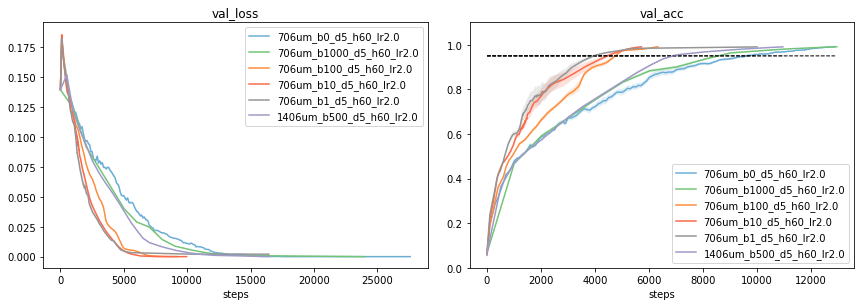

um_b1_d5_h60_lr2.0_rep0
b1 selected:  um_b1_d5_h60_lr2.0_rep0
integral_values {'um_b0_d5_h60_lr2.0_rep0': 0.13759467902783715, 'um_b1000_d5_h60_lr2.0_rep0': 0.12685276937229853, 'um_b100_d5_h60_lr2.0_rep1': 0.06467211728101166, 'um_b10_d5_h60_lr2.0_rep0': 0.018515168425490686, 'um_b500_d5_h60_lr2.0_rep0': 0.10879096322127625}
#logged paths : 5 
merged_2554964_0706_1449_synth_um_b0_d6_h60_lr2.0_rep0
#folds: 50
merged_2550709_0706_0057_synth_um_b1_d6_h60_lr2.0_rep0
#folds: 20
merged_2563535_0906_0313_synth_um_b10_d6_h60_lr2.0_rep0
#folds: 20
merged_2563555_0906_0457_synth_um_b100_d6_h60_lr2.0_rep0
#folds: 20
merged_2588815_1306_1132_synth_um_b1000_d6_h60_lr2.0_rep0
#folds: 20
um_b0_d6_h60_lr2.0_rep0
um_b1000_d6_h60_lr2.0_rep0
um_b100_d6_h60_lr2.0_rep0
um_b10_d6_h60_lr2.0_rep0
um_b1_d6_h60_lr2.0_rep0


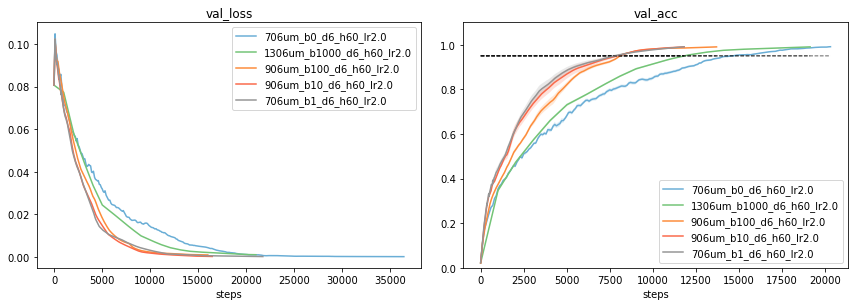

um_b1_d6_h60_lr2.0_rep0
b1 selected:  um_b1_d6_h60_lr2.0_rep0
integral_values {'um_b0_d6_h60_lr2.0_rep0': 0.1493420390090263, 'um_b1000_d6_h60_lr2.0_rep0': 0.11820183481532934, 'um_b100_d6_h60_lr2.0_rep0': 0.04196099898903793, 'um_b10_d6_h60_lr2.0_rep0': 0.007616952201772267}
#logged paths : 5 
merged_2555412_0706_1459_synth_um_b0_d7_h250_lr2.0_rep0
#folds: 50
merged_2556636_0706_1747_synth_um_b1_d7_h250_lr2.0_rep0
#folds: 9
merged_2555416_0706_1459_synth_um_b10_d7_h250_lr2.0_rep0
#folds: 9
merged_2588773_1306_1132_synth_um_b100_d7_h250_lr2.0_rep0
#folds: 16
merged_2588793_1306_1132_synth_um_b1000_d7_h250_lr2.0_rep0
#folds: 14
um_b0_d7_h250_lr2.0_rep0
um_b1000_d7_h250_lr2.0_rep0
um_b100_d7_h250_lr2.0_rep0
um_b10_d7_h250_lr2.0_rep0
um_b1_d7_h250_lr2.0_rep0


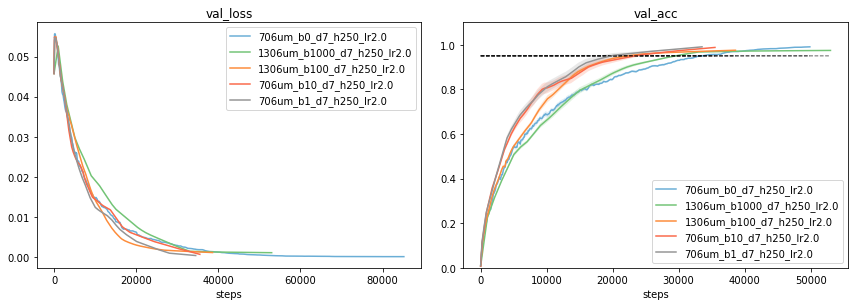

um_b1_d7_h250_lr2.0_rep0
b1 selected:  um_b1_d7_h250_lr2.0_rep0
integral_values {'um_b0_d7_h250_lr2.0_rep0': 0.08689568284242617, 'um_b1000_d7_h250_lr2.0_rep0': 0.0855001352705561, 'um_b100_d7_h250_lr2.0_rep0': 0.033162153795729434, 'um_b10_d7_h250_lr2.0_rep0': 0.011892361411309445}
#logged paths : 3 
merged_2556663_0706_1827_synth_um_b0_d8_h500_lr5.0_rep0
#folds: 10
merged_2556673_0706_2203_synth_um_b1_d8_h500_lr5.0_rep0
#folds: 10
merged_2556683_0806_0049_synth_um_b10_d8_h500_lr5.0_rep0
#folds: 9
um_b0_d8_h500_lr5.0_rep0
um_b10_d8_h500_lr5.0_rep0
um_b1_d8_h500_lr5.0_rep0


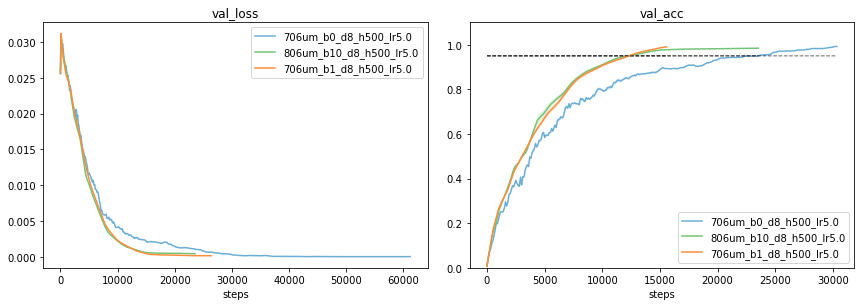

um_b1_d8_h500_lr5.0_rep0
b1 selected:  um_b1_d8_h500_lr5.0_rep0
integral_values {'um_b0_d8_h500_lr5.0_rep0': 0.08689078078699626, 'um_b10_d8_h500_lr5.0_rep0': -0.0045920135195328116}


In [49]:
integral_values_dict = dict()
patts_to_search2 = ['synth_um_b[051]*_d5_h60_lr2','synth_um_b[051]*_d6_h60_lr2', 'synth_um_b[015]*_d7_h250_lr2', 'synth_um_b[051]*_d8_h500_lr5'] # 'synth_um_b[01]*_d9_h1000_lr5']
#patts_to_search2 = ['synth_split_b0_d5','synth_split_b1_d5','synth_split_b10+_d5','synth_split_b[0-9]*_d5_h[0-9]+_lr1.0']
#patts_to_search2 = ['synth_split_*_d5','synth_split_*_d6','synth_split_*_d7',]
# MERGED_LOG_PATH DL_LOG_PATH

for patt in patts_to_search2: 
    val_accs_dict = plot_runs_w_regex(patt, 0.022, MERGED_LOG_PATH, verbose=False, delete_dir=False)
    integral_values, name, b0_max_idx = compute_integral_values(val_accs_dict)
    print('integral_values', integral_values)
    integral_values_dict[name] = (integral_values, b0_max_idx)

[12865, 1000, 100, 10, 500] [0.13759467902783715, 0.12685276937229853, 0.06467211728101166, 0.018515168425490686, 0.10879096322127625]
[20335, 1000, 100, 10] [0.1493420390090263, 0.11820183481532934, 0.04196099898903793, 0.007616952201772267]
[49872, 1000, 100, 10] [0.08689568284242617, 0.0855001352705561, 0.033162153795729434, 0.011892361411309445]
[30205, 10] [0.08689078078699626, -0.0045920135195328116]


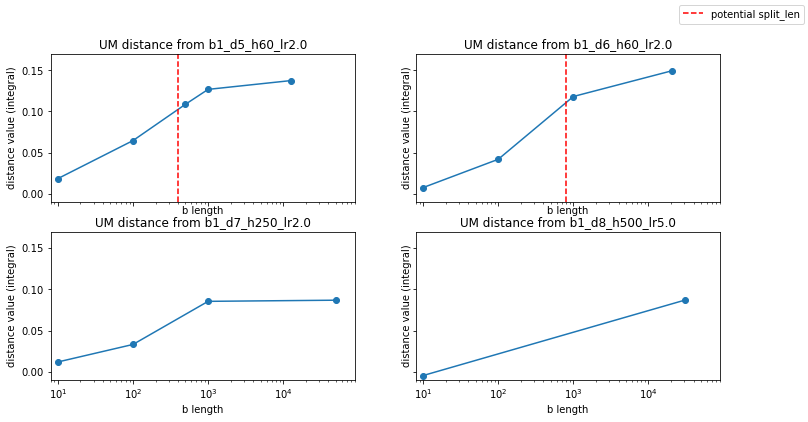

In [63]:
import seaborn as sns
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

def sigmoid(x):
    return 1 / (1 + np.exp(-1*x))
    
f, ax = plt.subplots(2, 2, sharex=True, sharey=True)
f.set_size_inches(12,6)
for i, (b1_run_name, dx_dict) in enumerate(integral_values_dict.items()):
    dx_dict, b0_max_idx = dx_dict
    b1_run_name = b1_run_name[3:b1_run_name.rfind('_')]
    x_val_list, y_val_list = [], []
    for run_hash1, run_value1 in dx_dict.items():
        matched = re.search('_b([051]+)_', run_hash1)
        if matched:
            y_val_list.append(run_value1)
            b_len = int(matched.group(1))
            if b_len == 0: b_len = b0_max_idx
            x_val_list.append(b_len)
    
    print(x_val_list, y_val_list)
    y_val_list = [y for _, y in sorted(zip(x_val_list, y_val_list))]
    x_val_list = [x for x, _ in sorted(zip(x_val_list, y_val_list))]
    #def objective(x, a, b):
    #    res=[]
    #    for el in x:
    #        res.append(sigmoid(a*el+b))                  
    #    return a * np.power(x,2) + b
    
    #f2 = np.interp(x_val_list, y_val_list)
    
    #if len(x_val_list) > 2:
    #    print(x_val_list, y_val_list)
    #    popt, _ = curve_fit(objective, x_val_list, y_val_list)
    #    a, b = popt
    #    print('y = %.5f * log (%.5f * x )' % (a, b))
    #    new_x = np.arange(10,1e5)
    #    ax[i//2][i%2].plot(new_x, objective(new_x, a, b))
    
    ax[i//2][i%2].plot(x_val_list, y_val_list)
    ax[i//2][i%2].set_title(f'UM distance from {b1_run_name}')
    ax[i//2][i%2].scatter(x_val_list, y_val_list, marker='o')
    ax[i//2][i%2].set_xscale('log')
    ax[i//2][i%2].set_xlabel('b length')
    ax[i//2][i%2].set_ylabel('distance value (integral)')
    ax[i//2][i%2].set_ylim((-0.01, 0.17))
    bottom, top = ax[i//2][i%2].get_xlim()  # return the current ylim
    ax[i//2][i%2].set_xlim((8, 1e5-1e4))
#f.tight_layout(pad=0.9, w_pad=0.9, h_pad=1.0)
ax[0][0].plot(np.ones(100)*400, np.linspace(-0.01, 0.17, 100), color='red', linestyle='--', label = 'potential split_len')
ax[0][1].plot(np.ones(100)*800, np.linspace(-0.01, 0.17, 100), color='red', linestyle='--')
f.legend()
plt.show()
    

## MNIST Dataset

#logged paths : 8 
2593243_1406_1515_mnist_um_b0_d3_h100_lr5.0_rep0
fold_0  #logged: 64, Max_acc: 0.255 unsuccessful run
2593242_1406_1515_mnist_um_b0_d3_h100_lr2.0_rep0
fold_0  #logged: 63, Max_acc: 0.255 unsuccessful run
2593241_1406_1515_mnist_um_b0_d3_h100_lr1.0_rep0
fold_0  #logged: 63, Max_acc: 0.255 unsuccessful run
2593202_1406_1444_mnist_um_b0_d3_h200_lr0.1_rep0
fold_0  #logged: 129, Max_acc: 0.95 unsuccessful run
2593240_1406_1515_mnist_um_b0_d3_h100_lr0.1_rep0
fold_0  #logged: 1235, Max_acc: 0.947 unsuccessful run
2593225_1406_1501_mnist_um_b0_d3_h100_lr0.1_rep0
fold_0  #logged: 1235, Max_acc: 0.966 unsuccessful run
2593203_1406_1444_mnist_um_b1_d3_h200_lr0.1_rep0
fold_0  #logged: 17, Max_acc: 0.935 unsuccessful run
2593260_1406_1543_mnist_um_b0_d3_h100_lr0.01_rep0
fold_0  #logged: 1072, Max_acc: 0.979 Max_step: 53550 
#folds: 1
um_b0_d3_h100_lr0.01_rep0


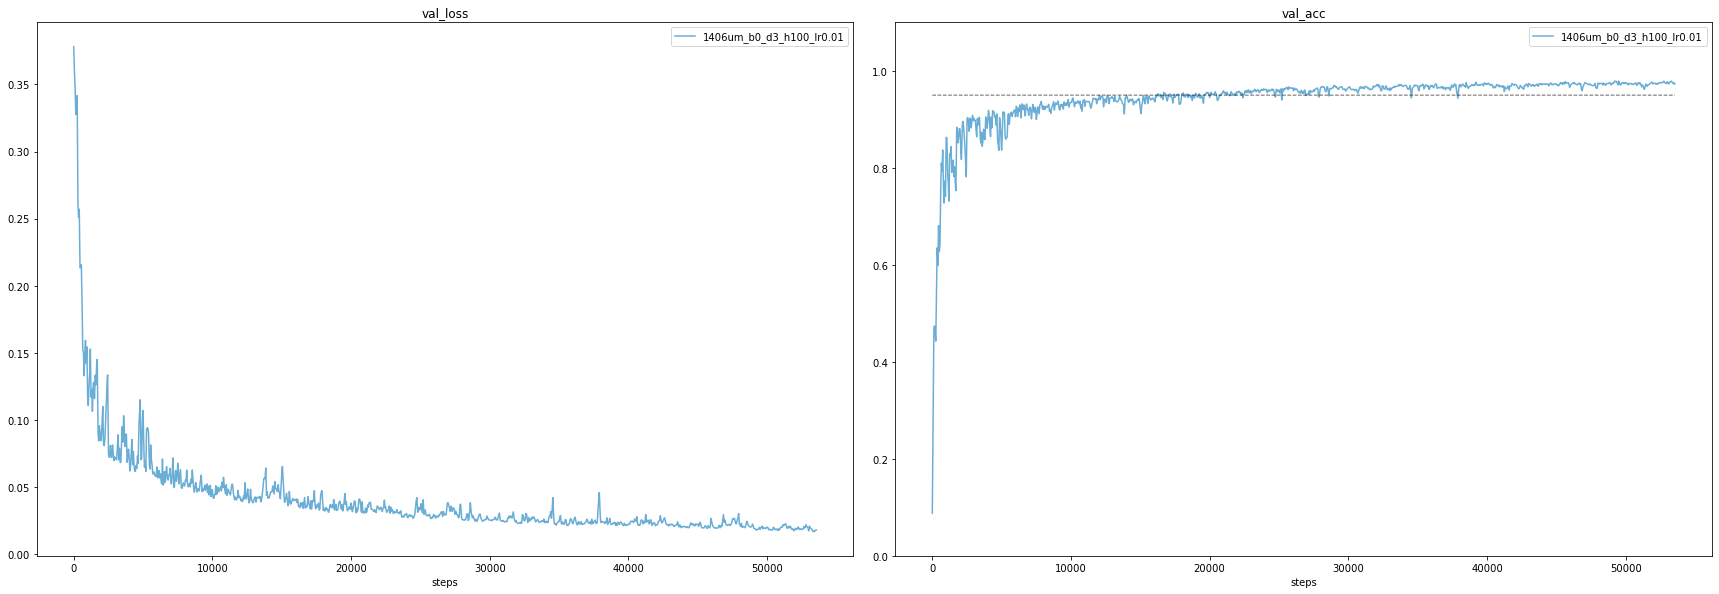

ERROR: No b1 run found as baseline
integral_values ({}, '')


In [101]:
integral_values_dict = dict()
patts_to_search2 = ['mnist_']
#patts_to_search2 = ['synth_split_b0_d5','synth_split_b1_d5','synth_split_b10+_d5','synth_split_b[0-9]*_d5']
#patts_to_search2 = ['synth_split_*_d5','synth_split_*_d6','synth_split_*_d7',]

# Mnist lr is 0.01
for patt in patts_to_search2: 
    val_accs_dict = plot_runs_w_regex(patt, 0.97, DL_LOG_PATH, verbose=True, delete_dir=False)
    integral_values = compute_integral_values(val_accs_dict)
    print('integral_values', integral_values)
    integral_values_dict[patt] = integral_values

# Log folds merger

In [7]:
import shutil
import itertools
from collections import Counter
from more_itertools import locate

def get_len_vals(dest_path):
    event_acc_old = EventAccumulator(dest_path)
    event_acc_old.Reload()
    try:
        _, step_nums, vals = zip(*event_acc.Scalars('val_acc'))
        return len(vals)
    except:
        return 0
    
def rename_w_rep(log_path):
    all_ckpt_dirs=os.listdir(log_path)
    all_ckpt_dirs = [el for el in all_ckpt_dirs if "DS_Store" not in el]
    for log_dir in all_ckpt_dirs:
        if not 'rep' in log_dir:
            fold_x = os.listdir(join(log_path,log_dir,'metrics'))
            fold_x = [el for el in fold_x if 'fold' in el]
            fold_nb = int(re.match('fold_([0-9]+)', fold_x).group(1))
            os.rename(join(log_path,log_dir), join(log_path,f'{log_dir}_rep{fold_nb}'))
            
def get_folds_to_merge(log_path, all_ckpt_dirs):
    
    patt = "(?:merged_)*([0-9]+)_[0-9]+_[0-9]+_[a-z]+_((?:um|rand|split)_b[0-9]+_d[0-9]+_h[0-9]+_lr[0-9]+)"
    matched = [re.match(patt, el) for el in all_ckpt_dirs]
    hashes = [el.group(2) for el in matched] # create hashes
    counts = Counter(hashes)
    dup_hashes = [i for i in counts.keys() if counts[i] > 1] # keep only ckpts w duplicates
    dup_hashes = np.array(dup_hashes)
    print(dup_hashes)
    folds_to_merge = [all_ckpt_dirs[list(locate(hashes, lambda x: x == hash1))] for hash1 in dup_hashes] # get the actual paths
    print(folds_to_merge)
    folds_to_merge = [[join(log_path, fold, 'metrics') for fold in folds] for folds in folds_to_merge]
    return folds_to_merge
    
def merge_folds(log_path=LOG_PATH):
    rename_w_rep(log_path)
    all_ckpt_dirs = os.listdir(log_path)
    all_ckpt_dirs = np.array([el for el in all_ckpt_dirs if "DS_Store" not in el])
    
    #all_ckpt_dirs = [el for el in all_ckpt_dirs if re.search(re_patt_to_search, el)]
    folds_to_merge = get_folds_to_merge(log_path, all_ckpt_dirs)
    
    for folds in folds_to_merge: 
        for i, fold in enumerate(folds): 
            assert(os.path.isdir(fold))
            folds_x = os.listdir(fold)
            if len(folds_x) < 1:
                shutil.rmtree(fold)
                del folds[i]
            ds_store=join(fold, '.DS_Store')
            if os.path.isdir(ds_store): os.remove(ds_store)
    
    for folds in folds_to_merge:
        # find smallest fold nb
        prev_fold_nb = 100
        for i, fold in enumerate(folds):
            print(fold)
            min_fold_nb = int(re.match('[a-z0-9./_]*rep([0-9]+)', fold).group(1))
            folds_x = os.listdir(fold)
            folds_x = [el for el in folds_x if "DS_Store" not in el]
            merged_folds_nb = [int(re.match('fold_([0-9]+)', fold_x).group(1)) for fold_x in folds_x]
            if min_fold_nb < prev_fold_nb or ('merged' in fold):
                prev_fold_nb = min_fold_nb
                prev_fold_idx = i
                dest_path = fold
                merged_folds_nb = merged_folds_nb
                if ('merged' in fold): break
        
        if not 'merged' in dest_path:
            dest_path_idx = [i for i, letter in enumerate(dest_path) if letter == '/']
            dest_path_pre = dest_path[:dest_path_idx[2]]
            dest_path_ckpt = dest_path[dest_path_idx[2]+1:dest_path_idx[3]]
            dest_fold_path = dest_path[:dest_path_idx[-1]]
            new_dest_ckpt = f'merged_{dest_path_ckpt}'
            new_dest_fold_path = join(dest_path_pre, new_dest_ckpt)
            os.rename(dest_fold_path, new_dest_fold_path)
            del folds[prev_fold_idx]
            dest_path = join(new_dest_fold_path, 'metrics')
        
        for fold in folds:
            list_folds = os.listdir(fold)
            list_folds = [el for el in list_folds if "DS_Store" not in el]
            foldnb2 = int(re.match('fold_([0-9]+)', list_folds[0]).group(1))
            source_path = join(fold, list_folds[0])
            #print('dest_fold_nb', dest_path, merged_folds_nb, 'foldnb2', source_path, foldnb2)
            merged_folds_nb.append(foldnb2)
            do_move=True

            # Check if file already exists
            hyp_dest_path = join(dest_path, f'fold_{foldnb2}')
            #print(hyp_dest_path, source_path)
            if os.path.isdir(hyp_dest_path):
                print(hyp_dest_path,'exists in the destination path!')
                #rename incoming folder to part2
                new_source_path = join(source_path[:source_path.rfind('/')], f'fold_{foldnb2}_part2')
                os.rename(source_path, new_source_path)
                source_path = new_source_path
                
            if do_move:
                shutil.move(source_path, dest_path)

            folder = source_path[:source_path[:source_path.rfind('/')].rfind('/')]
            #print("TO remove", folder)
            shutil.rmtree(folder)
                

#27147228_2504_1617_synth_um_b0_d8_h300_lr5
!cd $DL_LOG_PATH
!find . -name '.DS_Store' -type f -delete
!echo DONE
merge_folds(TO_MERGE_LOG_PATH)




DONE
[]
[]


In [8]:
def clean_folds(log_path=LOG_PATH):    
    all_ckpt_dirs = os.listdir(log_path)
    all_ckpt_dirs = [el for el in all_ckpt_dirs if "DS_Store" not in el]
    all_ckpt_dirs = [join(log_path, ckpt_path, 'metrics') for ckpt_path in all_ckpt_dirs]
    
    for ckpt in all_ckpt_dirs:
        folds = os.listdir(ckpt)
        for el in folds:
            if 'fold' not in el:
                el = join(ckpt, el)
                if os.path.isdir(el):
                    shutil.rmtree(el)
                else:
                    os.remove(el)
                
#clean_folds(log_path=DL_LOG_PATH)    

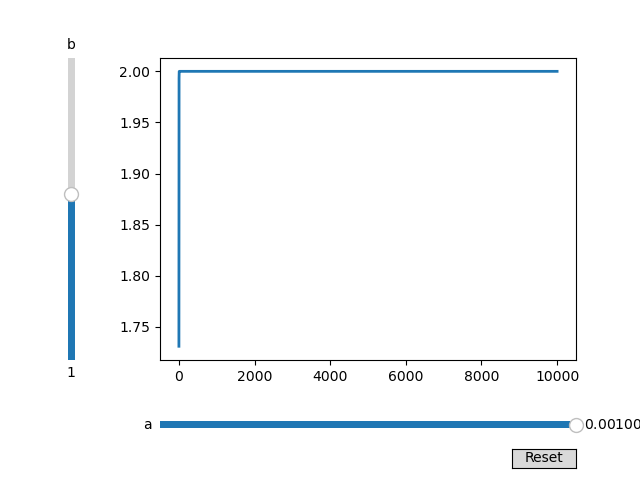

In [25]:
from matplotlib.widgets import Slider, Button

def sigmoid(x, a, b):
    return 1 / (1 + np.exp(-x*a)) + b

x_list = np.arange(1,1e4)
init_b=1
init_a=1

fig, ax = plt.subplots()
line, = plt.plot(x_list, sigmoid(x_list, init_a, init_b), lw=2)
plt.subplots_adjust(left=0.25, bottom=0.25)
axfreq = plt.axes([0.25, 0.1, 0.65, 0.03])
a_slider = Slider(
    ax=axfreq,
    label='a',
    valmin=0.00001,
    valmax=0.001,
    valinit=init_a,
)

axamp = plt.axes([0.1, 0.25, 0.0225, 0.63])
b_slider = Slider(
    ax=axamp,
    label='b',
    valmin=-10.0,
    valmax=10.0,
    valinit=init_b,
    orientation='vertical'
)

def update(val):
    line.set_ydata(sigmoid(x_list,a_slider.val, b))
    line.set_ydata(sigmoid(x_list, a, b_slider.val))
    fig.canvas.draw_idle()

# register the update function with each slider
a_slider.on_changed(update)
b_slider.on_changed(update)

# Create a `matplotlib.widgets.Button` to reset the sliders to initial values.
resetax = plt.axes([0.8, 0.025, 0.1, 0.04])
button = Button(resetax, 'Reset', hovercolor='0.975')

def reset(event):
    a_slider.reset()
    b_slider.reset()
button.on_clicked(reset)


plt.show()
